# Classification dengan Algoritma K-Nearest Neighbors (KNN)

Sebelumnya telah dibuat sebuah dummy dataset yaitu `Dataset Pinjaman` yang akan digunakan untuk Classification. Di sini akan dilakukan proses Classification dengan dataset tersebut menggunakan algoritma K-Nearest Neighbors (KNN). Beberapa hal yang akan dilakukan adalah:
- Import Modules dan Load Dataset
- Data Preprocessing
- Modelling dengan K-Nearest Neighbors (KNN)
- Evaluasi Performa Model
- Hyperparameter Tuning dan Cross Validation

## Import Modules dan Load Dataset

Hal pertama yang akan dilakukan adalah meng-import beberapa modules dan me-load dataset yang akan digunakan.

Beberapa modules yang akan digunakan adalah:
- pandas, untuk me-load dan mengolah dataset
- numpy, untuk melakukan operasi matematika dan transformasi data
- seaborn & pyplot, untuk melakukan visualisasi data
- resample, untuk melakukan peng-handle-an terhadap imbalanced data dengan teknik under sampling
- LabelEncoder, untuk melakukan encoding terhadap data kategorik
- MinMaxScaler, untuk melakukan scalling terhadap data numerik
- train_test_split, untuk memisahkan dataset menjadi training dan testing data
- KNeighborsClassifier, sebagai algoritma untuk melakukan proses Classification
- classification_report, sebagai media untuk melakukan evaluasi performa model
- GridSearchCV, untuk melakukan  cross validation dan hyperparameter tuning

In [32]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

Sedangkan dataset yang akan digunakan adalah `Dataset Pinjaman` yang merupakan dummy dataset yang sebelumnya telah dibuat. Kolom `id` pada dataset tidak akan digunakan dalam proses Classification, sehingga kolom tersebut akan dibuang (dropped). Dataset akan di-load menggunakan pandas dengan variable `df` dan akan dibuat dataset backup dengan variable `df_backup`.

In [2]:
df = pd.read_csv('../1-membuat-dummy-dataset/dataset/datasetPinjaman.csv')
df_backup = df.copy(deep = True)
df.drop(columns = ['id'], inplace = True)

## Data Preprocessing

Proses selanjutnya yaitu data preprocessing. Dataset yang telah di-load perlu melalui serangkaian proses terlebih dahulu sebelum digunakan untuk proses Classification. Serangkaian proses yang akan dilakukan adalah:
- Deteksi dan Handle Outlier
- Deteksi dan Handle Duplicated Data
- Deteksi dan Handle Imbalanced Data
- Encoding Data Kategorik
- Normalization Data Numerik
- Splitting Training dan Testing Data

### Deteksi dan Handle Outlier

Data outlier perlu dihandle karena dapat berpengaruh buruk terhadap performa model Classification. Deteksi dan peng-handle-an terhadap data outlier hanya dilakukan untuk data numerik. Peng-handle-an data outlier dilakukan dengan cara mengganti data outlier dengan suatu nilai tertentu.

Untuk melakukan deteksi terhadap outlier, dapat dilakukan dengan cara mem-plot data ke dalam boxplot. Data outlier akan terlihat sebagai titik-titik pada boxplot. Untuk melakukannya dapat dengan mengeksekusi perintah berikut ini.

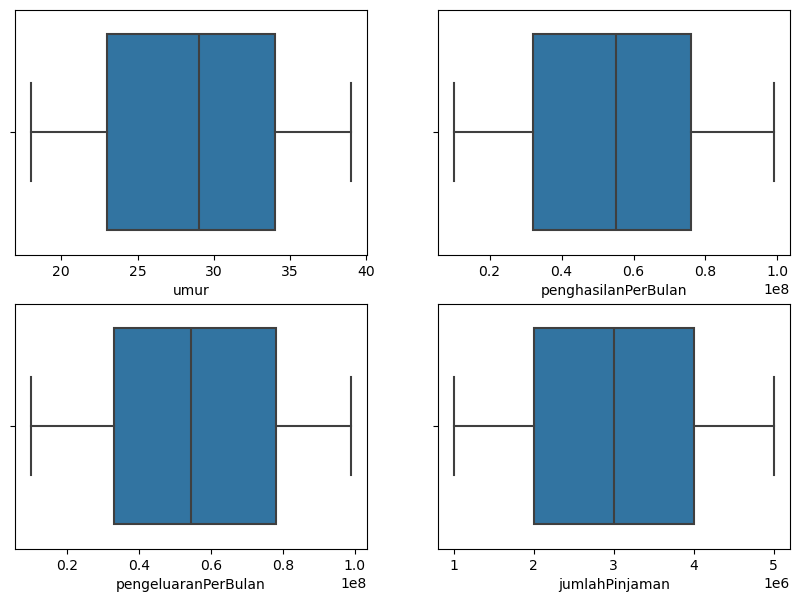

In [10]:
fig, ax = plt.subplots(2, 2, figsize = (10, 7))
for col, ax in zip(df.drop(columns = 'pinjamanDiTerima').select_dtypes(['int', 'float']).columns, ax.flatten()):
    sb.boxplot(data = df, x = col, ax = ax)

Terlihat bahwa tidak ada titik-titik pada boxplot. Artinya data yang digunakan telah bebas dari data outlier. Maka tidak perlu dilakukan peng-handle-an terhadap data outlier.

### Deteksi dan Handle Duplicated Data

Duplicated data juga dapat berpengaruh buruk terhadap performa model Classification sehingga perlu dihandle. Peng-handle-an terhadap duplicated data dilakukan dengan cara membuang baris yang terindikasi sebagai duplicated data.

Untuk melakukan deteksi terhadap duplicated data, dapat mengeksekusi perintah berikut ini.

In [12]:
df.duplicated().value_counts()

False    1997
True        3
Name: count, dtype: int64

Index `True` di atas menyatakan jumlah baris yang terindikasi sebagai duplicated data. Untuk meng-handle-nya dapat mengeksekusi perintah berikut ini.

In [13]:
df.drop_duplicates(inplace = True)

Untuk mengcek kembali apakah masih terdapat duplicated data, jalankan kembali perintah berikut ini.

In [14]:
df.duplicated().value_counts()

False    1997
Name: count, dtype: int64

Terlihat bahwa sudah tidak ada duplicated data.

### Deteksi dan Handle Imbalanced Data

Data target yang tidak seimbang (imbalanced data) perlu di-handle karena akan membuat model cenderung memprediksi terhadap data yang bersifat mayoritas, sehingga model menjadi bias. Peng-handle-an terhadap imbalanced data dilakukan dengan teknik resampling (dalam kasus ini, undersampling).

Untuk mendeteksi adanya imbalanced data pada data target, dapat menjalankan perintah berikut ini.

In [15]:
df['pinjamanDiTerima'].value_counts()

pinjamanDiTerima
0    1176
1     821
Name: count, dtype: int64

Terlihat bahwa data target bernilai 0 jumlahnya lebih besar (mayoritas) daripada data target bernilai 1, sehingga diperlukan peng-handle-an. Peng-handle-an dengan teknik undersampling dapat dilakukan dengan mengeksekusi perintah berikut ini.

In [16]:
df_minor = df[df['pinjamanDiTerima'] == 1]
df_major = df[df['pinjamanDiTerima'] == 0]

df_major_undersampling = resample(
    df_major,
    replace = False,
    n_samples = len(df_minor),
    random_state = 42
)

df = pd.concat([df_minor, df_major_undersampling])

Untuk mengcek kembali apakah masih terdapat dimbalanced data, jalankan kembali perintah berikut ini.

In [17]:
df['pinjamanDiTerima'].value_counts()

pinjamanDiTerima
1    821
0    821
Name: count, dtype: int64

Terlihat bahwa data target sudah seimbang, maka proses peng-handle-an berhasil dilakukan. Hanya saja, jumlah entri data berkurang. Ini perlu dipikirkan, bisa jadi berkurangnya jumlah entri data juga berpengaruh buruk terhadap performa model. Namun pada kesempatan kali ini, kita kesampingkan hal tersebut terlebih dahulu.

### Encoding Data Kategorik

Algoritma Machine Learning hanya dapat memproses data yang bertipe numerik. Oleh karena itu, data dengan tipe kategorik harus dilakukan proses encoding terlebih dahulu untuk mengubah tipe data kategorik tersebut menjadi numerik.

Pada kesempatan ini, data kategorik akan diencode dengan Label Encoder. Untuk melakukannya dapat mengeksekusi perintah di bawah ini.

In [24]:
encoder = LabelEncoder()
for col in df_backup.drop(columns = ['id', 'pinjamanDiTerima']).select_dtypes(['object']).columns:
    df[col] = encoder.fit_transform(df[col])

Untuk mengcek apakah proses encoding berhasil dilakukan, jalankan perintah di bawah ini.

In [25]:
df.head()

,jenisKelamin,umur,sudahMenikah,melampirkanKTP,penghasilanPerBulan,pengeluaranPerBulan,jumlahPinjaman,pinjamanDiTerima
1,1,31,1,1,90000000,31000000,4000000,1
3,0,23,1,1,97000000,74000000,3000000,1
4,0,27,1,1,79000000,65000000,3000000,1
9,0,35,1,1,92000000,14000000,5000000,1
12,0,27,1,1,76000000,57000000,4000000,1


Terlihat bahwa data kategorik, yaitu kolom `jenisKelamin`, `sudahMenikah`, dan `melampirkanKTP` telah berhasil di-encode menjadi numerik.

### Normalization Data Numerik

Terdapat algoritma Classification yang sensitif terhadap jarak, terutama jika kolom-kolom numerik pada suatu data memiliki orde yang berbeda (misalnya suatu kolom berorde satuan, deangkan kolom lainnya berorde jutaan). Maka data tersebut harus ditransformasikan. Terdapat dua jenis transformasi, yaitu Normalization dan Standardization. Pada kesempatan ini hanya akan dilakukan Normalization dengan Min Max Scaler.

Untuk melakukan proses normalization data numerik, dapat mengeksekusi perintah di bawah ini.

In [26]:
scaler = MinMaxScaler()
for col in df_backup.drop(columns = ['id', 'pinjamanDiTerima']).select_dtypes(['int', 'float']).columns:
    df[col] = scaler.fit_transform(np.array(df[col]).reshape(-1, 1))

Untuk mengcek apakah proses normalization telah berhasil dilakukan, jalankan perintah di bawah ini.

In [27]:
df.head()

,jenisKelamin,umur,sudahMenikah,melampirkanKTP,penghasilanPerBulan,pengeluaranPerBulan,jumlahPinjaman,pinjamanDiTerima
1,1,0.619048,1,1,0.898876,0.235955,0.75,1
3,0,0.238095,1,1,0.977528,0.719101,0.50,1
4,0,0.428571,1,1,0.775281,0.617978,0.50,1
9,0,0.809524,1,1,0.921348,0.044944,1.00,1
12,0,0.428571,1,1,0.741573,0.528090,0.75,1


Terlihat bahwa data numerik, yaitu kolom `umur`, `penghasilanPerBulan`, `pengeluaranPerBulan `dan `jumlahPinjaman` telah berhasil dilakukan proses normalization.

### Splitting Training dan Testing Data

Untuk melakukan proses Classification, sebuah data harus dipecah menjadi dua, yaitu training data dan testing data. Training data digunakan untuk melatih model Classification agar dapat melakukan prediksi terhadap data lain. Testing data digunakan untuk menguji dan mengevaluasi performa model Classification.

Untuk melakukan proses ini, dapat menjalankan perintah di bawah ini.

In [28]:
X = df.drop(columns = 'pinjamanDiTerima')
y = df['pinjamanDiTerima']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    stratify = y,
    random_state = 42
)

## Modelling dengan K-Nearest Neighbors (KNN)

Di sinilah proses Classification dimulai. Model yang akan digunakan adalah K-Nearest Neighbors. Model akan dilatih menggunakan training data dan diuji serta dievaluasi menggunakan testing data.

Proses modelling dapat dilakukan dengan mengeksekusi perintah di bawah ini.

In [29]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

Tampilan di atas mengindikasikan proses modelling telah berhasil dilakukan.

In [31]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9558263518659559, 0.9209726443768997)

## Evaluasi Performa Model

In [37]:
y_pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(152, 13, 13, 151)

In [46]:
print((tp) / (tp + fn))


print(classification_report(y_test, y_pred))

0.9207317073170732
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       165
           1       0.92      0.92      0.92       164

    accuracy                           0.92       329
   macro avg       0.92      0.92      0.92       329
weighted avg       0.92      0.92      0.92       329



In [76]:
y_test.to_list()[:10]

[0, 0, 0, 1, 1, 0, 0, 1, 1, 0]

[0, 0, 0, 1, 1, 0, 0, 1, 0, 0]

In [79]:
df.corr()[df.corr().index == 'pinjamanDiTerima'].drop(columns = 'pinjamanDiTerima')

,melampirkanKTP,penghasilanPerBulan,pengeluaranPerBulan
pinjamanDiTerima,0.306968,0.529162,-0.543822


In [101]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

clf1 = KNeighborsClassifier()
clf2 = RandomForestClassifier()

pipeline = Pipeline([
    ('classifier', clf1)
])

params_grid = [
    {
    'classifier__n_neighbors' : [x for x in range(1, 6, 2)],
    'classifier__weights'     : ['uniform', 'distance'],
    'classifier__p'           : [1, 2],
    'classifier'              : [clf1]
},
    {
    'classifier__n_estimators' : [50, 100],
    'classifier'               : [clf2]
}
]

model_tuning   = GridSearchCV(
    estimator  = pipeline,
    param_grid = params_grid,
    cv         = 3,
    n_jobs     = -1,
    verbose    = 1

)

In [102]:
model_tuning.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [1, 3, 5],
                          'classifier__p': [1, 2],
                          'classifier__weights': ['uniform', 'distance']},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__n_estimators': [50, 100]}],
             verbose=1)

In [111]:
pd.DataFrame(model_tuning.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__n_neighbors,param_classifier__p,param_classifier__weights,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
13,0.421648,0.130143,0.027104,0.001043,RandomForestClassifier(),NaN,NaN,NaN,100,"{'classifier': RandomForestClassifier(), 'clas...",0.949772,0.974886,0.970252,0.964970,0.010912,1
12,0.464611,0.015435,0.039244,0.001411,RandomForestClassifier(),NaN,NaN,NaN,50,"{'classifier': RandomForestClassifier(), 'clas...",0.942922,0.974886,0.972540,0.963449,0.014546,2
9,0.003326,0.002353,0.014973,0.002554,KNeighborsClassifier(),5,1,distance,NaN,"{'classifier': KNeighborsClassifier(), 'classi...",0.906393,0.901826,0.913043,0.907088,0.004606,3
10,0.008729,0.001106,0.069690,0.003016,KNeighborsClassifier(),5,2,uniform,NaN,"{'classifier': KNeighborsClassifier(), 'classi...",0.904110,0.904110,0.908467,0.905562,0.002054,4
11,0.006255,0.003097,0.013635,0.001620,KNeighborsClassifier(),5,2,distance,NaN,"{'classifier': KNeighborsClassifier(), 'classi...",0.899543,0.906393,0.908467,0.904801,0.003813,5
8,0.008758,0.001717,0.071377,0.002826,KNeighborsClassifier(),5,1,uniform,NaN,"{'classifier': KNeighborsClassifier(), 'classi...",0.904110,0.899543,0.906178,0.903277,0.002772,6
7,0.006073,0.004307,0.015070,0.002193,KNeighborsClassifier(),3,2,distance,NaN,"{'classifier': KNeighborsClassifier(), 'classi...",0.890411,0.913242,0.903890,0.902514,0.009371,7
2,0.026652,0.004712,0.086288,0.004712,KNeighborsClassifier(),1,2,uniform,NaN,"{'classifier': KNeighborsClassifier(), 'classi...",0.881279,0.899543,0.910755,0.897192,0.012148,8
3,0.012640,0.008977,0.013900,0.008610,KNeighborsClassifier(),1,2,distance,NaN,"{'classifier': KNeighborsClassifier(), 'classi...",0.881279,0.899543,0.910755,0.897192,0.012148,8
5,0.006233,0.003292,0.016580,0.007891,KNeighborsClassifier(),3,1,distance,NaN,"{'classifier': KNeighborsClassifier(), 'classi...",0.881279,0.910959,0.897025,0.896421,0.012124,10


In [104]:
model_tuning.score(X_test, y_test)

0.9756838905775076

In [106]:
y_test.to_list()[:10]

[0, 0, 0, 1, 1, 0, 0, 1, 1, 0]

In [107]:
y_pred = model_tuning.predict(X_test)
list(y_pred[:10])

[0, 0, 0, 1, 1, 0, 0, 1, 1, 0]

In [108]:
model_tuning.score(X_train, y_train)

1.0